In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import re
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import animation

from datatools import config, utils
from datatools.evaluate_events import align_true_and_pred, evaluate_time_location_grid
from datatools.animator import Animator
from datatools.postprocess import classify_episode_starts, detect_events, plot_events
from dataset import SoccerWindowTensors
from models.set_lstm import SetLSTM
from models.utils import build_model, load_trial_args, resolve_model_path
from inference import inference, inference_episode

torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
pd.set_option("display.float_format", lambda x: f"{x:.4f}".rstrip("0").rstrip("."))
pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

### Testing SoccerWindowDataset

In [ ]:
TRACKING_DIR = "data/sportec/tracking_processed"
tracking_paths = np.sort([f"{TRACKING_DIR}/{f}" for f in os.listdir(TRACKING_DIR)])[:1]
dataset = SoccerWindowTensors(
    tracking_paths,
    node_in_dim=8,
    team_size=11,
    fps=25.0,
    sample_freq=5,
    window_seconds=10.0,
    window_stride=1,
    self_loops=True,
    flip_pitch=False,
    verbose=True,
)
len(dataset)

Building window samples: 100%|██████████| 1/1 [00:09<00:00,  9.54s/it]


12702

### Testing Trained Models

In [4]:
TRACKING_DIR = "data/sportec/tracking_processed"
EVENT_DIR = "data/sportec/event_rdp"
match_id = np.sort([f.split(".")[0] for f in os.listdir(TRACKING_DIR)])[-1]
tracking = pd.read_parquet(f"{TRACKING_DIR}/{match_id}.parquet")
events = pd.read_parquet(f"{EVENT_DIR}/{match_id}.parquet")
events

,frame_id,period_id,episode_id,timestamp,player_id,event_type,x,y
0,10000,1,1,00:00.00,home_28,pass,52.83,34.33
1,10045,1,1,00:01.80,home_33,control,28.2,36.98
2,10083,1,1,00:03.32,home_33,pass,28.88,36.71
3,10162,1,1,00:06.48,home_9,pass,72.57,10.72
4,10186,1,1,00:07.44,home_28,pass,82.63,17.01
...,...,...,...,...,...,...,...,...
1852,173773,2,91,49:10.92,home_5,None,31.71,54.15
1853,173805,2,91,49:12.20,home_5,interception,22.2,56.82
1854,173811,2,91,49:12.44,away_25,control,21.7,57.77
1855,173887,2,91,49:15.48,away_25,pass,18.39,60.41


In [59]:
trial = 656
device = "cuda:3"
save_path = f"saved/{trial:03d}"

trial_args = load_trial_args(save_path)
model = build_model(trial_args, device=device)

target_type = trial_args.get("micro_type", "edge")
model_name = "state_dict_best_pe.pt" if target_type == "ball" else "state_dict_best_acc.pt"
model_path = resolve_model_path(save_path, model_name)

state_dict = torch.load(model_path, map_location=device, weights_only=False)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [60]:
macro_prev, macro_next, micro_pred, stats = inference(
    model,
    tracking,
    use_crf=trial_args.get("crf_weight", 0) > 0,
    decode="indep",
    window_seconds=trial_args.get("window_seconds", None),
    correct_episode_lasts=True,
)
stats

Phase 1: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]


{'n_frames': 17168,
 'edge_acc': 0.6426,
 'src_acc': 0.7513,
 'dst_acc': 0.7853,
 'forbid_rate': 0.0,
 'edge_acc_window': 0.6467}

In [58]:
pred_events = detect_events(tracking, micro_pred)
stats, alignments = align_true_and_pred(events, pred_events, threshold=1.0)
stats

100%|██████████| 92/92 [00:04<00:00, 22.37it/s]


,pred_count,true_count,matched,precision,recall,f1
event_type,,,,,,
kick,1155,1117,797,0.69,0.7135,0.7016
control,826,654,504,0.6102,0.7706,0.6811
out,42,60,38,0.9048,0.6333,0.7451
total,2023,1831,1339,0.6619,0.7313,0.6949


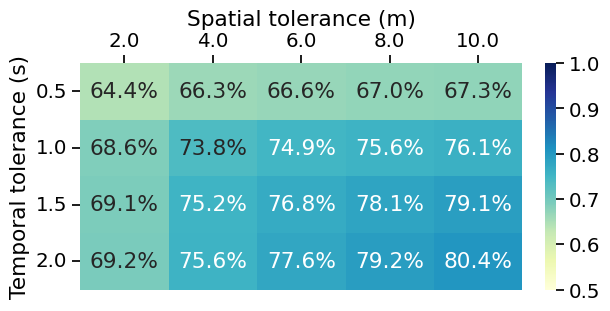

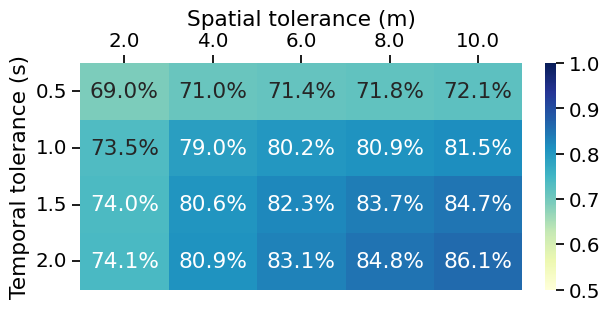

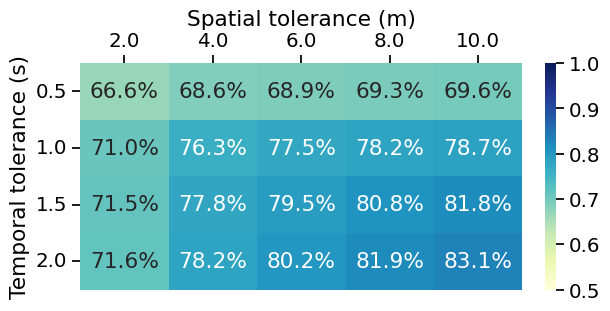

thres_dist,2,4,6,8,10
thres_frames,,,,,
12.5,0.6661,0.6857,0.6893,0.693,0.6962
25,0.7099,0.7632,0.7748,0.7816,0.7869
37.5,0.7147,0.778,0.7948,0.808,0.818
50,0.7157,0.7816,0.8022,0.8191,0.8312


In [6]:
prec_df, recall_df, f1_df = evaluate_time_location_grid(alignments, visualize=True)
f1_df

In [10]:
import datatools.matplotsoccer as mps

In [18]:
pred_events = detect_events(tracking, micro_pred)
pred_events = classify_episode_starts(pred_events)
episode_starts = pred_events.groupby("episode_id").head(1)
episode_starts["event_type"].value_counts()

100%|██████████| 93/93 [00:00<00:00, 195.30it/s]


event_type
pass        35
throw_in    35
goalkick    16
corner       6
Name: count, dtype: int64

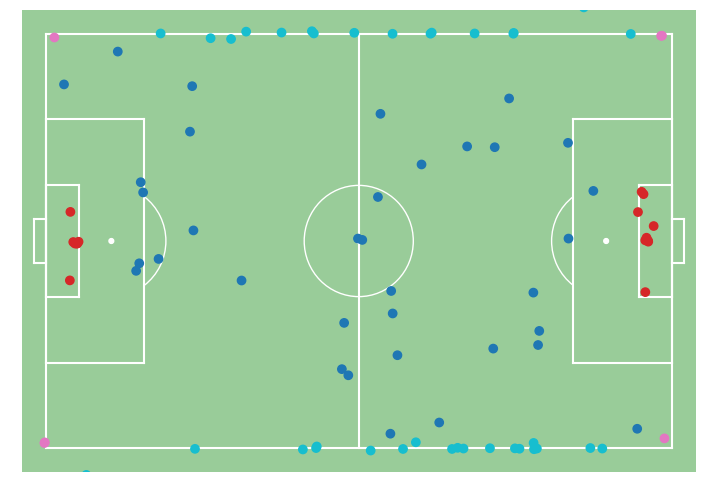

In [20]:
fig, ax = plt.subplots(figsize=(9, 6))
mps.field("green", config.PITCH_X, config.PITCH_Y, fig, ax, show=False)
color_dict = {"pass": 0, "goalkick": 1, "corner": 2, "throw_in": 3, "control": 4}
# true_colors = true_setpieces["event_type"].map(color_dict)
pred_colors = episode_starts["event_type"].map(color_dict)
# ax.scatter(true_setpieces["x"], true_setpieces["y"], c=true_colors, cmap="tab10")
ax.scatter(episode_starts["start_x"], episode_starts["start_y"], c=pred_colors, cmap="tab10")

In [6]:
pred_events.to_parquet(f"data/sportec/event_rdp_pred/{match_id}.parquet")

### Visualization

(<Figure size 1458x720 with 2 Axes>, <Axes: >)

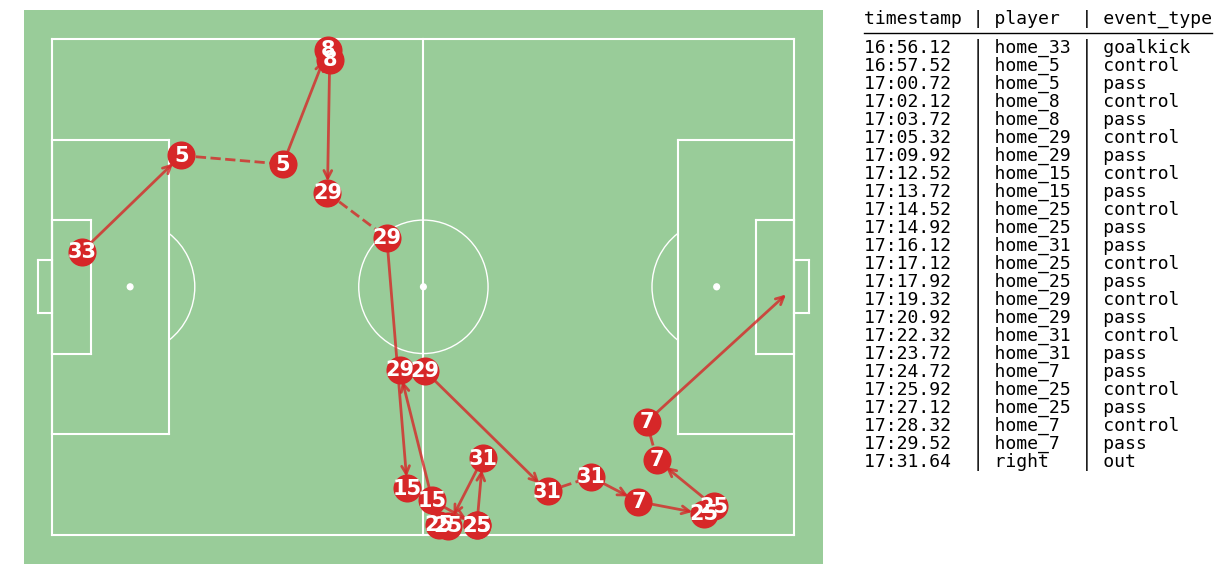

In [44]:
episode_id = 19
ep_tracking = tracking[tracking["episode_id"] == episode_id].set_index("frame_id")[:1500]
ep_pred_events = pred_events[pred_events["frame_id"].isin(ep_tracking.index)]
plot_events(ep_pred_events)

(<Figure size 972x480 with 2 Axes>, <Axes: >)

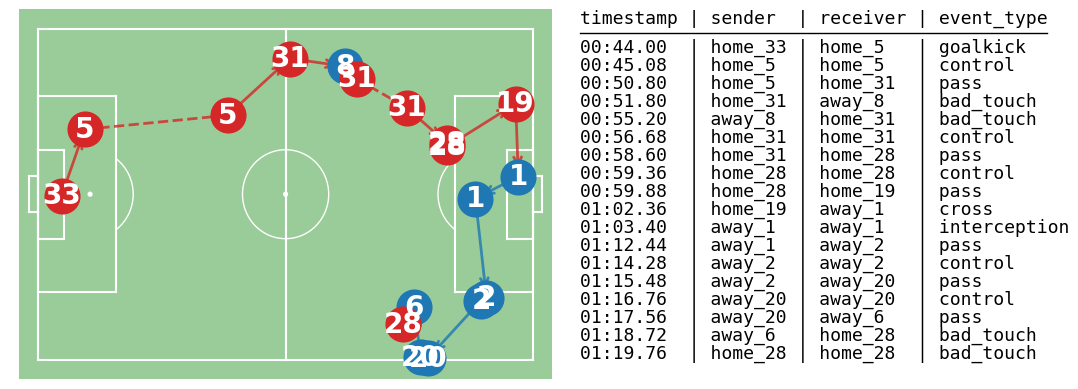

In [40]:
episode_id = 2
ep_tracking = tracking[tracking["episode_id"] == episode_id].set_index("frame_id")

ep_true_events = events[events["frame_id"].isin(ep_tracking.index)].copy()[:-2]
ep_true_events.rename(columns={"x": "start_x", "y": "start_y"}, inplace=True)
ep_true_events["end_x"] = ep_true_events["start_x"].shift(-1)
ep_true_events["end_y"] = ep_true_events["start_y"].shift(-1)

last_idx = ep_true_events.index[-1]
ep_true_events.at[last_idx, "end_x"] = ep_true_events.at[last_idx, "start_x"]
ep_true_events.at[last_idx, "end_y"] = ep_true_events.at[last_idx, "start_y"]

plot_events(ep_true_events, figsize=(7.2, 4.8))

(<Figure size 972x480 with 2 Axes>, <Axes: >)

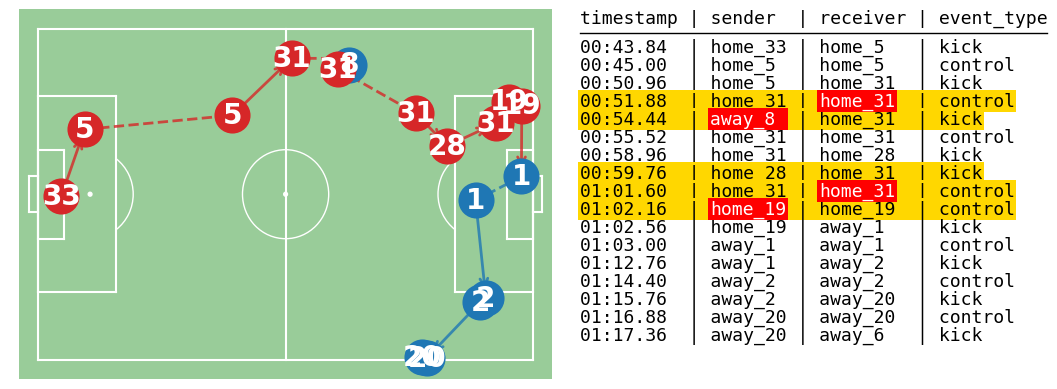

In [39]:
episode_id = 2
ep_tracking = tracking[tracking["episode_id"] == episode_id].set_index("frame_id")
ep_pred_events = pred_events[pred_events["frame_id"].isin(ep_tracking.index)]
ep_alignments = alignments[alignments["episode_id"] == episode_id]
# focus_box = ((32, 70), (58, 52))
plot_events(ep_pred_events, ep_alignments, figsize=(7.2, 4.8))

In [ ]:
# track_dict = {"main": ep_tracking, "darkorange": micro_pred_df.loc[ep_tracking.index]}
track_dict = {"main": ep_tracking}
use_crf = trial_args.get("crf_weight", 0) > 0
show_events = False

if use_crf and show_events:
    anim_path = f"animations/{match_id}_EP{episode_id:03d}_T{trial:03d}_table.mp4"
else:
    anim_path = f"animations/{match_id}_EP{episode_id:03d}_T{trial:03d}.mp4"

if use_crf:
    ep_events = ep_pred_events.copy()
    ep_events["timestamp"] = ep_events["timestamp"].apply(utils.timestamp_to_seconds)
    edge_seq = micro_pred.loc[ep_tracking.index]
    animator = Animator(track_dict, events=ep_events, edge_seq=edge_seq, show_events=show_events)
else:
    edge_weights = micro_pred.loc[ep_tracking.index]
    animator = Animator(track_dict, edge_weights=edge_weights)

anim = animator.run()
writer = animation.FFMpegWriter(fps=25)
os.makedirs("animations", exist_ok=True)
anim.save(anim_path, writer=writer)

### Event Heatmaps

In [ ]:
from datatools.event_postprocessing import prepare_events
from application.event_heatmap.generate_visualization import compare_event_heatmaps

In [53]:
true_events = prepare_events(events, tracking)
pred_events = prepare_events(pred_events, tracking)

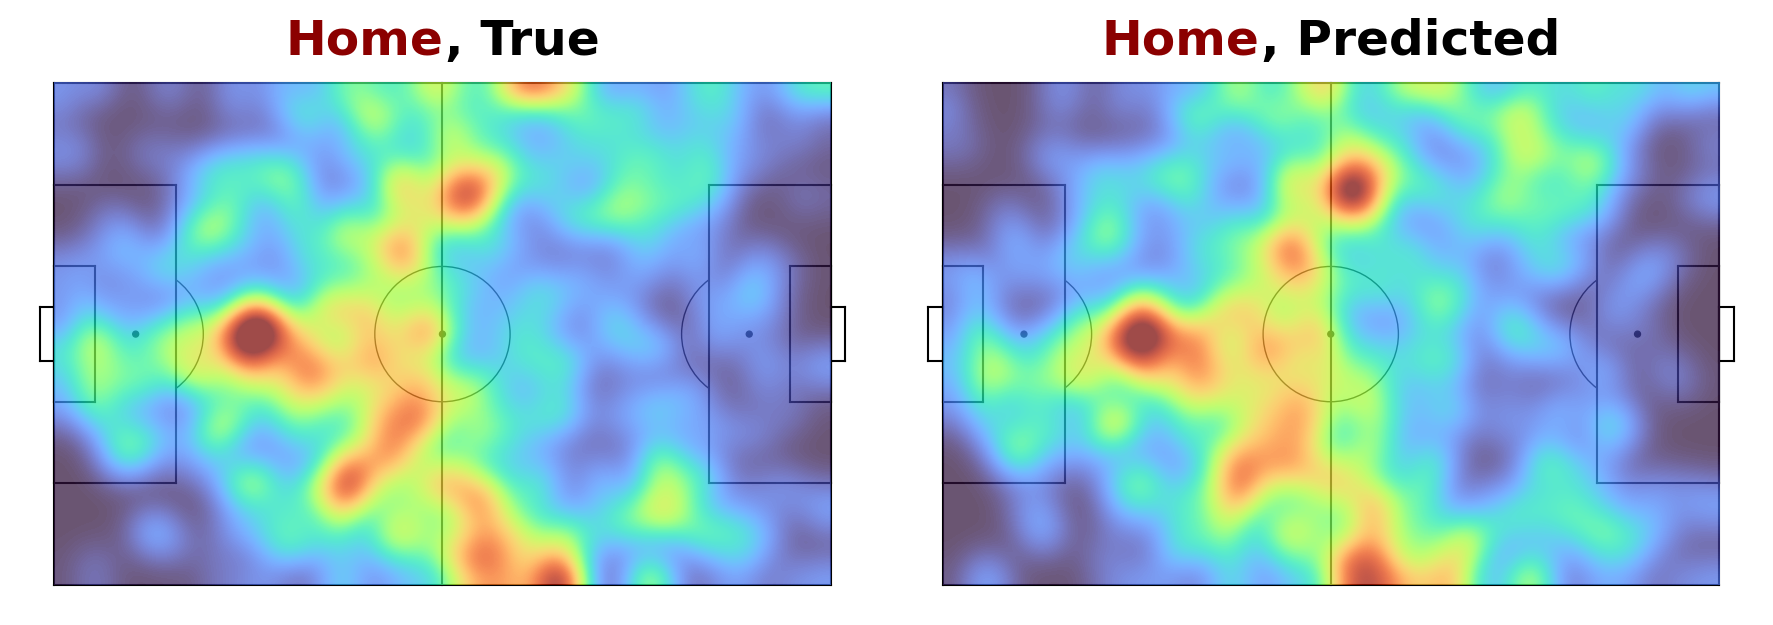

In [ ]:
compare_event_heatmaps(true_events, pred_events, "home", vmax=0.0005, show_cbar=False)

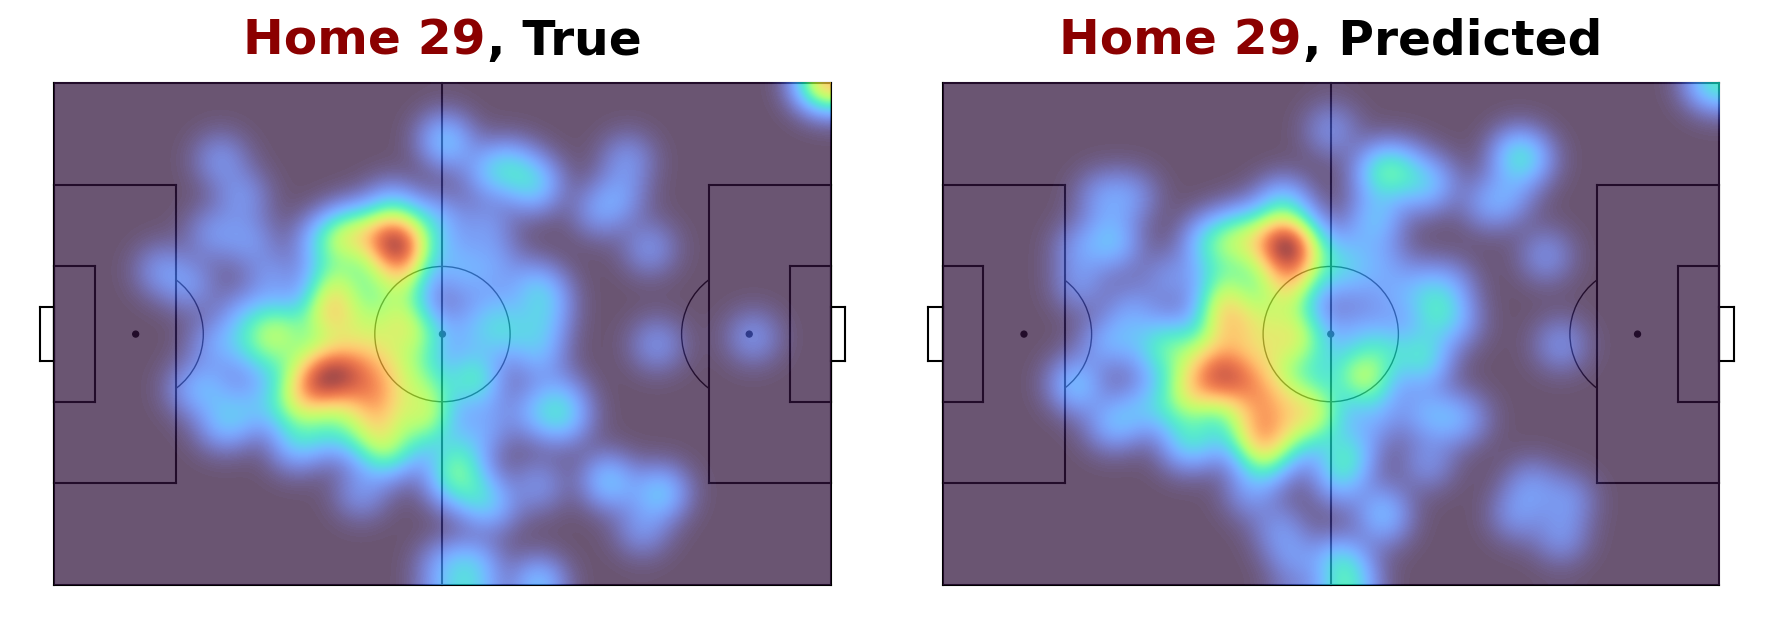

In [86]:
compare_event_heatmaps(true_events, pred_events, "home_29", show_cbar=False)

### Possession Share Timeline

In [132]:
from application.possession.possession_metrics import infer_team_poss, home_poss_by_time
from application.possession.generate_visualization import plot_true_pred_poss

In [133]:
true_events = prepare_events(events, tracking)
pred_events = prepare_events(pred_events, tracking)

frame_cols = ["frame_id", "period_id", "timestamp", "episode_id"]
frames = tracking.loc[tracking["episode_id"] > 0, frame_cols].copy()
frames["true_team"] = infer_team_poss(true_events, tracking, mode="split")
frames["pred_team"] = infer_team_poss(pred_events, tracking, mode="split")
frames = frames.dropna(subset="true_team").copy()

print((frames["true_team"] == frames["pred_team"]).mean())
frames

0.9240246647285004


,frame_id,period_id,timestamp,episode_id,true_team,pred_team
0,10000,1,0,1,home,home
1,10001,1,0.04,1,home,home
2,10002,1,0.08,1,home,home
3,10003,1,0.12,1,home,home
4,10004,1,0.16,1,home,home
...,...,...,...,...,...,...
142319,173965,2,2958.6,91,away,away
142320,173966,2,2958.64,91,away,away
142321,173967,2,2958.68,91,away,away
142322,173968,2,2958.72,91,away,away


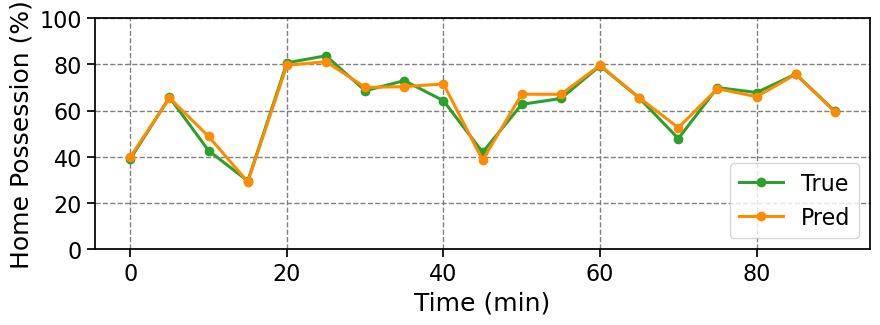

(<Figure size 1000x300 with 1 Axes>,
 <Axes: xlabel='Time (min)', ylabel='Home Possession (%)'>)

In [136]:
home_poss = home_poss_by_time(frames, bin_minutes=5)
home_poss = home_poss[home_poss["true_home_poss"] > 0]
plot_true_pred_poss(
    home_poss["true_home_poss"],
    home_poss["pred_home_poss"],
    x=home_poss["minute"],
    grid=True,
)

### Pass Networks

In [124]:
from application.passmap.generate_visualization import (
    get_node_positions_per_phase,
    get_edges_per_phase,
    aggregate_phases_hungarian,
    aggregate_edges,
    draw_pass_map,
)
from application.passmap.stats import compute_passmap_stats

In [46]:
phase_nodes = get_node_positions_per_phase(tracking)
true_edges = get_edges_per_phase(true_events, tracking)
pred_edges = get_edges_per_phase(pred_events, tracking)

nodes_h, glob_h, hist_h = aggregate_phases_hungarian(phase_nodes, {}, "home")
true_edges_h = aggregate_edges(true_edges, phase_nodes, glob_h, hist_h, "home")
pred_edges_h = aggregate_edges(pred_edges, phase_nodes, glob_h, hist_h, "home")

nodes_a, glob_a, hist_a = aggregate_phases_hungarian(phase_nodes, {}, "away")
true_edges_a = aggregate_edges(true_edges, phase_nodes, glob_a, hist_a, "away")
pred_edges_a = aggregate_edges(pred_edges, phase_nodes, glob_a, hist_a, "away")

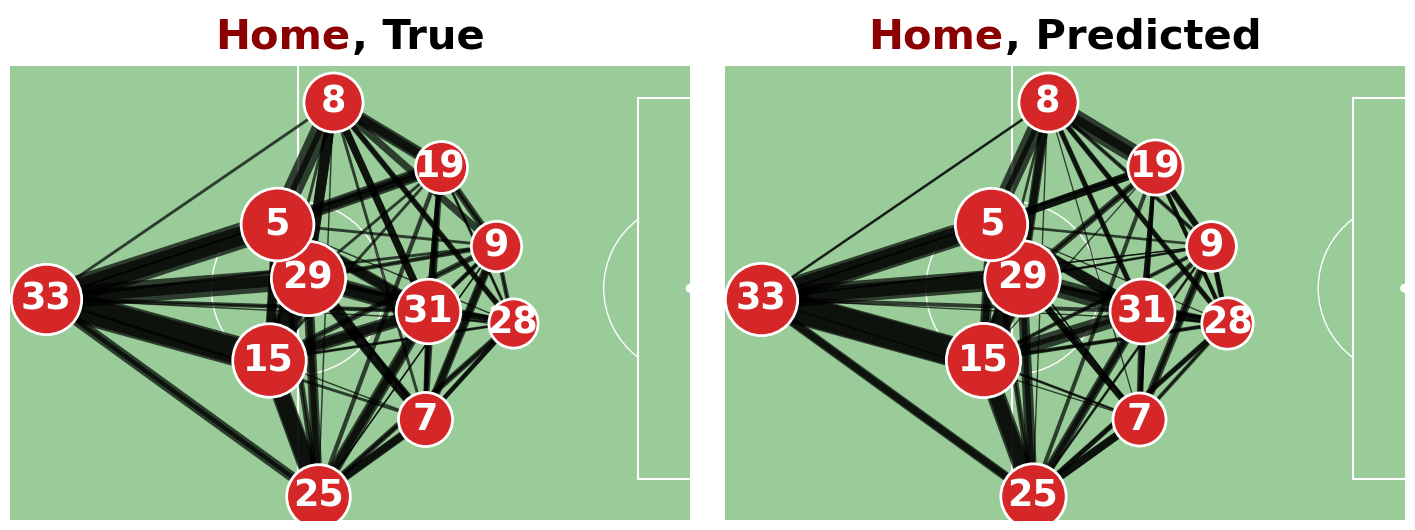

In [121]:
fig_h, ax_h = plt.subplots(1, 2, figsize=(18, 9), facecolor="white")
draw_pass_map(nodes_h, true_edges_h, ax_h[0], "Home, True", crop_x=36, crop_y=24)
draw_pass_map(nodes_h, pred_edges_h, ax_h[1], "Home, Predicted", crop_x=36, crop_y=24)
fig_h.subplots_adjust(wspace=0.05, top=0.9)

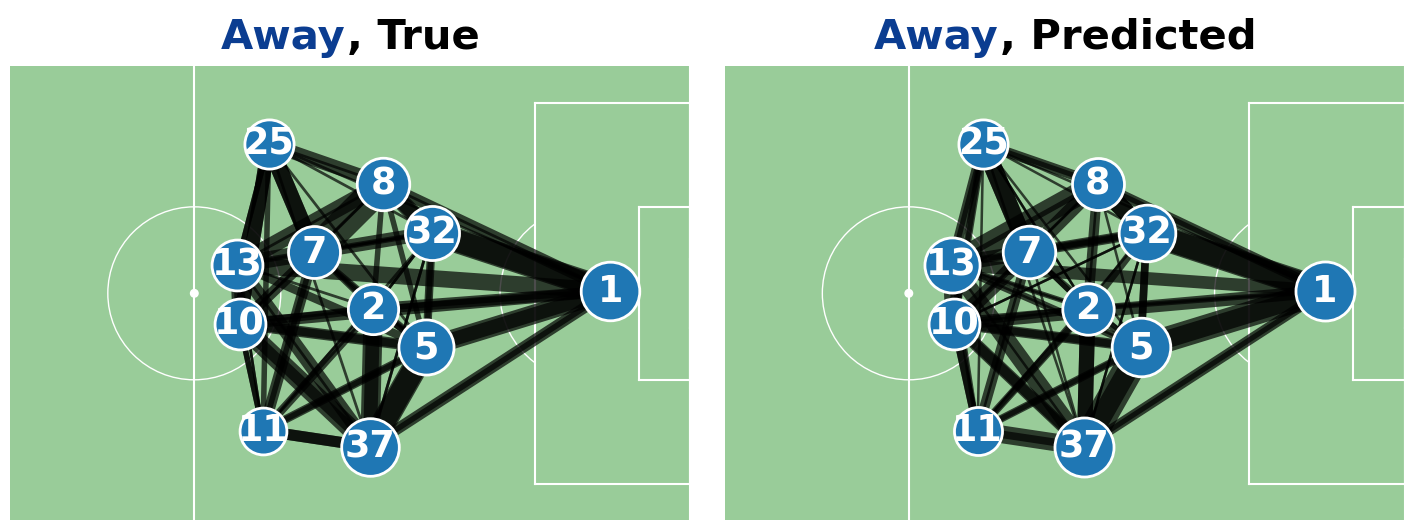

In [122]:
fig_a, ax_a = plt.subplots(1, 2, figsize=(18, 9), facecolor="white")
draw_pass_map(nodes_a, true_edges_a, ax_a[0], "Away, True", crop_x=36, crop_y=24)
draw_pass_map(nodes_a, pred_edges_a, ax_a[1], "Away, Predicted", crop_x=36, crop_y=24)
fig_a.subplots_adjust(wspace=0.05, top=0.9)

In [128]:
compute_passmap_stats(nodes_h, true_edges_h, pred_edges_h)

{'mean_node_degree': 45.18181818181818,
 'mae_node_degree': 2.6363636363636362,
 'mean_edge_weight': 5.177083333333333,
 'mae_edge_weight': 1.0792079207920793,
 'jensen_shannon': 0.022848237786501517,
 'spectral_dist': 0.0270269476631971}

In [130]:
compute_passmap_stats(nodes_a, true_edges_a, pred_edges_a)

{'mean_node_degree': 24.272727272727273,
 'mae_node_degree': 2.727272727272727,
 'mean_edge_weight': 3.2560975609756095,
 'mae_edge_weight': 1.053763440860215,
 'jensen_shannon': 0.05519497540543703,
 'spectral_dist': 0.013819485058024687}